In [1]:
from PINN.pinn_solver_mimo import PINNSolver
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

from pickle import dump, load
from sklearn.preprocessing import MinMaxScaler
import time
import pandas as pd

from PIL import Image


# For LSTM model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.models import load_model
from tqdm.keras import TqdmCallback


DTYPE = 'float32'


class SPINN(PINNSolver):
    def __init__(self, x_r, u_r, y_r, s1, s2, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.K11 = 2.0
        self.K12 = 0
        self.K21 = 0
        self.K22 = 1.0
        self.tau11 = 5.0
        self.tau12 = 5.0 
        self.tau21 = 5.0
        self.tau22 = 5.0
        self.x_r = x_r
        self.u = u_r
        self.y_r = y_r
        self.s1 = s1
        self.s2 = s2
        self.dt = 1
        self.files = []
        
    @tf.function
    def get_residual_loss(self):
 
        y = self.model(self.x_r)
            
        return self.residual_function(self.u, y)

    def residual_function(self, u, y_nn):
        """Residual of the ODE"""
        y = (y_nn - self.s2.min_) * 1/self.s2.scale_ + self.s2.data_min_

        y_t = (y[1:]-y[:-1]) / self.dt
        yn = y[0:-1]
        un = u[0:-1]
        
        res1 = self.tau11 * y_t[:,0] + yn[:,0] - self.K11 * un[:,0]
        res2 = self.tau22 * y_t[:,1] + yn[:,1] - self.K22 * un[:,1]

        return 1*res1, 1*res2

    def callback(self, *args):
        
        path = "figures_for_gif/"

        if self.iter % 10 == 0:
            print('It {:05d}: loss = {:10.8e}'.format(self.iter, self.current_loss)
                  )
        
        # making animation
#         y_meas = self.y_r # Data Range for Animation
#         y_nn = self.model(self.x_r)
#         y_meas = self.s2.inverse_transform(y_meas)
#         y_nn = self.s2.inverse_transform(y_nn)


#         plt.figure(0, figsize=(12,3))
# #         plt.subplot(2,1,1)
#         plt.plot(y_nn,'r-',label='LSTM')
#         plt.plot(y_meas,'b--',label='Measured')
#         plt.ylim([0,3.5])
#         plt.xlim([0,len(y_nn)])
#         plt.title('LSTM-Onestep model Validation',fontsize=15)
#         plt.ylabel("T1", fontsize=13)
#         plt.legend(loc=4,fontsize=13)
#         plt.text(10,2.5,"Training step: %i"%(self.iter+1),fontsize="xx-large",color="k")
#         plt.savefig(path + "animation{}.png".format(self.iter), bbox_inches='tight', transparent=True, pad_inches=0.1, dpi=100, facecolor="white")
#         plt.clf()
#         plt.close()

#         self.files.append(path + "animation{}.png".format(self.iter))
            
        self.hist.append(self.current_loss)
        self.iter += 1


In [2]:
# for creating animation
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

In [3]:
# Load Data
data1 = pd.read_pickle('MIMO_open_loop_data_start.pkl') # for LOSS 1 (NN Training)
data2 = pd.read_pickle('MIMO_open_loop_data_6000.pkl') # for Loss 2 (PINN) 

data1 = np.transpose(data1)
data2 = np.transpose(data2)

data2 = data2[0:1500]

data1=pd.DataFrame(data1)
data1.columns=['u1','u2','y1','y2']
data2 = pd.DataFrame(data2)
data2.columns=['u1','u2','y1','y2']

data3 = pd.concat([data1, data2], ignore_index=True) # for validation 

In [4]:
data3

,u1,u2,y1,y2
0,0.000000,0.000000,2.911058,1.009909
1,0.000000,0.000000,2.425882,0.841590
2,0.000000,0.000000,2.021568,0.701325
3,0.000000,0.000000,1.684640,0.584438
4,0.000000,0.000000,1.403867,0.487032
...,...,...,...,...
1695,0.740936,1.484565,1.387001,1.487087
1696,0.740936,1.484565,1.402813,1.486666
1697,0.740936,1.484565,1.415990,1.486316
1698,0.740936,1.484565,1.426970,1.486024


In [5]:
path ="figs_result/"

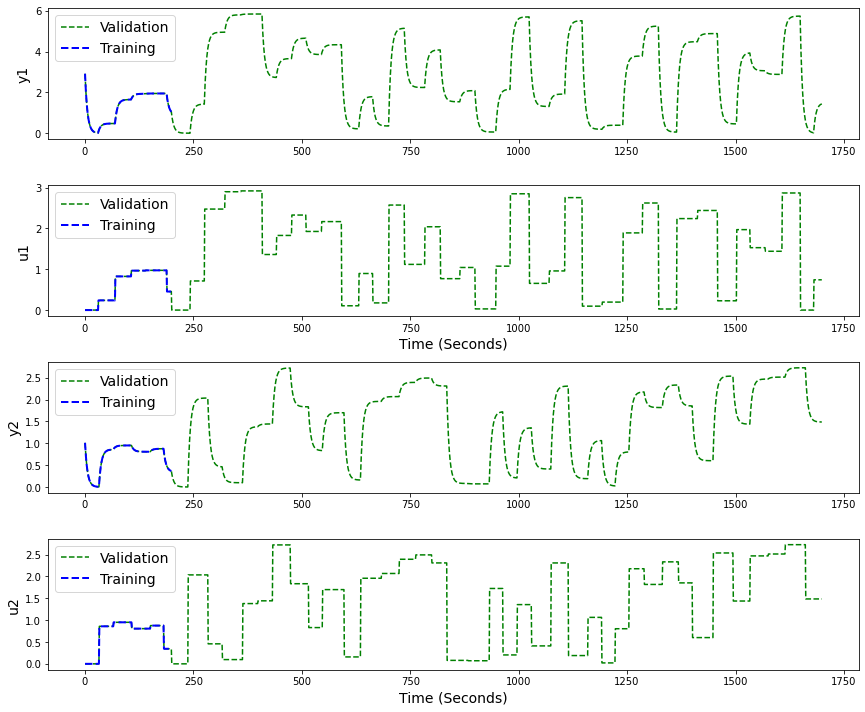

In [6]:
plt.figure(figsize=(12,10))
plt.subplot(411)
plt.plot(data3["y1"], 'g--',  label='Validation')
plt.plot(data1["y1"], 'b--', linewidth=2, label='Training')
plt.ylabel("y1",fontsize=14)
plt.legend(fontsize=14)

plt.subplot(412)
plt.plot(data3["u1"], 'g--',label='Validation')
plt.plot(data1["u1"], 'b--',linewidth=2,label='Training')
plt.ylabel("u1",fontsize=14)
plt.xlabel("Time (Seconds)", fontsize=14)
plt.legend(fontsize=14)

plt.subplot(413)
plt.plot(data3["y2"], 'g--',  label='Validation')
plt.plot(data1["y2"], 'b--', linewidth=2, label='Training')
plt.ylabel("y2",fontsize=14)
plt.legend(fontsize=14)

plt.subplot(414)
plt.plot(data3["u2"], 'g--',label='Validation')
plt.plot(data1["u2"], 'b--',linewidth=2,label='Training')
plt.ylabel("u2",fontsize=14)
plt.xlabel("Time (Seconds)", fontsize=14)
plt.legend(fontsize=14)

plt.tight_layout()

# plt.savefig(path + 'FOPDT Data for PINN training.eps', format='eps')
# plt.savefig(path + 'FOPDT Data for PINN training.png', format='png')

plt.show()


In [7]:
# Data scaling

# Scale features
s1 = MinMaxScaler(feature_range=(-1,1), copy=False)
s1.data_max_ = np.array([6,6,6,6])
s1.data_min_ = np.array([0,0,0,0])
s1.min_ = np.array([-1,-1,-1,-1])
s1.max_ = np.array([1,1,1,1])
s1.data_range_ = np.array([6,6,6,6])
s1.scale_ = np.array([2/6,2/6,2/6,2/6])

s2 = MinMaxScaler(feature_range=(-1,1), copy=False)
s2.data_max_ = np.array([6,6])
s2.data_min_ = np.array([0,0])
s2.data_range_ = np.array([6,6])
s2.min_ = np.array([-1,-1])
s2.max_ = np.array([1,1])
s2.scale_ = np.array([2/6, 2/6])

# Execute scaling
Xs1 = s1.transform(data1[['u1','u2','y1','y2']].to_numpy())
Ys1 = s2.transform(data1[['y1','y2']].to_numpy())

Xs2 = s1.transform(data3[['u1','u2','y1','y2']].to_numpy())
Ys2 = s2.transform(data3[['y1','y2']].to_numpy())

window = 5

# Save model parameters
model_params = dict()
model_params['Xscale'] = s1
model_params['yscale'] = s2
model_params['window'] = window

dump(model_params, open('model_param_mimo.pkl', 'wb'))

In [8]:
# Data Snap shots for training data

X_train = []
Y_train = []
for i in range(window,len(Xs1)):
    X_train.append(Xs1[i-window:i,:])
    Y_train.append(Ys1[i])

# Reshape data to format accepted by LSTM
X_train, Y_train = np.array(X_train), np.array(Y_train)

In [9]:
# Data Snap shots for validation data
X_val = []
Y_val = []
for i in range(window,len(Xs2)):
    X_val.append(Xs2[i-window:i,:])
    Y_val.append(Ys2[i])

# Reshape data to format accepted by LSTM
X_val, Y_val = np.array(X_val), np.array(Y_val)

In [10]:
#LSTM model 1 for PINN Off mode
model_lstm1 = Sequential()

model_lstm1.add(LSTM(units=100, return_sequences=True, \
          input_shape=(X_train.shape[1],X_train.shape[2])))
model_lstm1.add(Dropout(0.2))
model_lstm1.add(LSTM(units=100, return_sequences=True))
model_lstm1.add(Dropout(0.2))
model_lstm1.add(LSTM(units=100))
model_lstm1.add(Dropout(0.2))
model_lstm1.add(Dense(units=Y_train.shape[1])) #units = number of outputs
# model_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error',\
            #   metrics = ['accuracy'])
# Allow for early exit
es_lstm = EarlyStopping(monitor='loss',mode='min',verbose=1,patience=10)



# LSTM model 2 for PINN On mode
model_lstm2 = Sequential()

model_lstm2.add(LSTM(units=100, return_sequences=True, \
          input_shape=(X_train.shape[1],X_train.shape[2])))
model_lstm2.add(Dropout(0.2))
model_lstm2.add(LSTM(units=100, return_sequences=True))
model_lstm2.add(Dropout(0.2))
model_lstm2.add(LSTM(units=100))
model_lstm2.add(Dropout(0.2))
model_lstm2.add(Dense(units=Y_train.shape[1])) #units = number of outputs
# model_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error',\
            #   metrics = ['accuracy'])
# Allow for early exit
es_lstm = EarlyStopping(monitor='loss',mode='min',verbose=1,patience=10)


# input data ("u") for loss2 (pinn)
x_r = X_val # Scaled Snapshot of X to evaluating NN model

u_r = data3[["u1","u2"]].to_numpy()[window:Xs2.shape[0]] # Original u data evaluating residual
u_r = tf.convert_to_tensor(u_r, DTYPE)

y_r = Y_val # Scaled Snapshot of Y

solver1 = SPINN(model=model_lstm1, x_r=x_r,u_r=u_r, y_r=y_r, s1=s1, s2=s2, is_pinn=False)
solver2 = SPINN(model=model_lstm2, x_r=x_r,u_r=u_r, y_r=y_r, s1=s1, s2=s2, is_pinn=True)
# # Choose step sizes aka learning rate
# lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000, 5000], [1e-3, 1e-4, 1e-5])

# Solve with Adam optimizer
optim = tf.keras.optimizers.Adam()

X_train = tf.convert_to_tensor(X_train, DTYPE)
Y_train = tf.convert_to_tensor(Y_train, DTYPE)

Metal device set to: Apple M1 Pro


2022-06-04 11:39:57.838015: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-04 11:39:57.838163: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
# PINN Off case
solver1.is_pinn = False
solver1.solve_with_tf_optimizer(optim, X_train, Y_train, n_step=300)

2022-06-04 11:40:01.401715: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-04 11:40:01.406373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-04 11:40:01.465118: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] function_optimizer failed: INVALID_ARGUMENT: Input 0 of node zeros_like_20 was passed float from sequential/lstm/PartitionedCall:6 incompatible with expected variant.
2022-06-04 11:40:01.491844: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] tfg_optimizer{} failed: INVALID_ARGUMENT: Input 0 of node zeros_like_20 was passed float from sequential/lstm/PartitionedCall:6 incompatible with expected variant.
	when importing GraphDef to MLIR module in GrapplerHook
2022-06-04 11:40:01.496898: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] function_optimizer failed: INVALID_ARGUMENT: Input 0 of node zeros_lik

It 00000: loss = 5.03092945e-01
It 00010: loss = 3.79835963e-02
It 00020: loss = 3.94404605e-02
It 00030: loss = 2.03721561e-02
It 00040: loss = 1.47910798e-02
It 00050: loss = 1.01135112e-02
It 00060: loss = 4.80660237e-03
It 00070: loss = 2.54033227e-03
It 00080: loss = 2.17794278e-03
It 00090: loss = 2.02340004e-03
It 00100: loss = 1.79492519e-03
It 00110: loss = 1.64401042e-03
It 00120: loss = 1.48939237e-03
It 00130: loss = 1.35135360e-03
It 00140: loss = 1.21818308e-03
It 00150: loss = 1.09311217e-03
It 00160: loss = 9.77557967e-04
It 00170: loss = 8.72539298e-04
It 00180: loss = 7.79427704e-04
It 00190: loss = 6.99072087e-04
It 00200: loss = 6.31760806e-04
It 00210: loss = 5.77122963e-04
It 00220: loss = 5.34094812e-04
It 00230: loss = 5.01047878e-04
It 00240: loss = 4.76036279e-04
It 00250: loss = 4.57087735e-04
It 00260: loss = 4.42449964e-04
It 00270: loss = 4.30734508e-04
It 00280: loss = 4.20947035e-04
It 00290: loss = 4.12436522e-04


In [12]:
# save_gif_PIL("pinn_off.gif", solver1.files, fps=50, loop=0)  

In [13]:
#%% Save LSTM model file
solver1.model.save('PINN_FOPDT_mimo_onestep_LSTM_pinn_off.h5')

In [14]:
# #PINN On case
solver2.is_pinn = True
solver2.solve_with_tf_optimizer(optim, X_train, Y_train, n_step=300)

solver2.solve_with_scipy_optimizer(X_train, Y_train, method='L-BFGS-B')

2022-06-04 11:40:46.551888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-04 11:40:47.117254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-04 11:40:47.180714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-04 11:40:47.235531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-04 11:40:47.349386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-04 11:40:47.531859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-04 11:40:47.686865: I tensorflow/core/grappler/optimizers/cust

It 00000: loss = 7.71910477e+00
It 00010: loss = 1.46576345e+00
It 00020: loss = 6.84910297e-01
It 00030: loss = 3.65481585e-01
It 00040: loss = 3.36344063e-01
It 00050: loss = 2.65011132e-01
It 00060: loss = 2.12819621e-01
It 00070: loss = 1.67119503e-01
It 00080: loss = 1.26837537e-01
It 00090: loss = 1.00400805e-01
It 00100: loss = 8.41244757e-02
It 00110: loss = 7.03137517e-02
It 00120: loss = 5.79501726e-02
It 00130: loss = 4.72101569e-02
It 00140: loss = 3.82775217e-02
It 00150: loss = 3.15464512e-02
It 00160: loss = 2.66512558e-02
It 00170: loss = 2.26885080e-02
It 00180: loss = 1.91787295e-02
It 00190: loss = 1.60999112e-02
It 00200: loss = 1.35064106e-02
It 00210: loss = 1.14246849e-02
It 00220: loss = 9.82989278e-03
It 00230: loss = 8.63507483e-03
It 00240: loss = 7.72041455e-03
It 00250: loss = 6.97899889e-03
It 00260: loss = 6.34123897e-03
It 00270: loss = 5.77132497e-03
It 00280: loss = 5.25385235e-03
It 00290: loss = 4.78360476e-03


2022-06-04 11:41:44.771450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-04 11:41:45.221484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-04 11:41:45.275619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-04 11:41:45.328910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-04 11:41:45.484712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-04 11:41:45.985816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-04 11:41:46.101261: I tensorflow/core/grappler/optimizers/cust

It 00300: loss = 4.35599685e-03


      fun: 0.004255600273609161
 hess_inv: <203002x203002 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.24657846e-05, -7.83971263e-05,  4.65447374e-06, ...,
        8.01895570e-04,  2.20562378e-03,  7.15223188e-03])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 7
      nit: 5
     njev: 7
   status: 1
  success: False
        x: array([-0.0363405 ,  0.08585697, -0.03941713, ...,  0.12699578,
        0.00219161, -0.02186685])

In [15]:
solver2.model.save('PINN_FOPDT_mimo_onestep_LSTM_pinn_on.h5')

In [16]:
# save_gif_PIL("pinn_on.gif", solver2.files, fps=50, loop=0)  

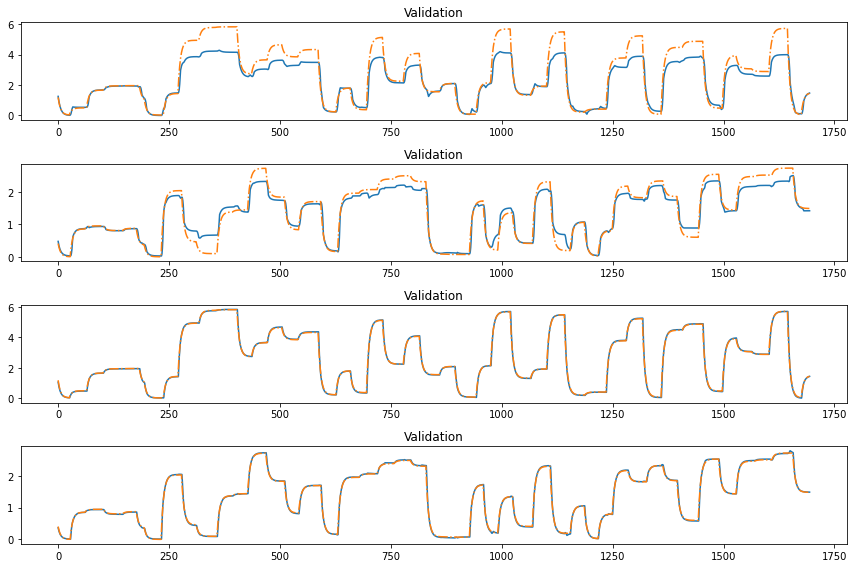

In [17]:
# Model evaluation with input datas (PINN off model)
ynn_off = solver1.model(X_val)
ynn_off = s2.inverse_transform(ynn_off)

# Model evaluation with input datas (PINN on model)
ynn_on = solver2.model(X_val)
ynn_on = s2.inverse_transform(ynn_on)

plt.figure(figsize=(12,8))
plt.subplot(4,1,1)
plt.gca().set_title('Validation')
plt.plot(ynn_off[:,0])
plt.plot(data3["y1"].to_numpy()[window:], '-.')
# plt.plot(validation["y"].to_numpy()[ynn_train_off.shape[0]+window+window:], '-.')

plt.subplot(4,1,2)
plt.gca().set_title('Validation')
plt.plot(ynn_off[:,1])
plt.plot(data3["y2"].to_numpy()[window:], '-.')
# plt.plot(validation["y"].to_numpy()[ynn_train_off.shape[0]+window+window:], '-.')


plt.subplot(4,1,3)
plt.gca().set_title('Validation')
plt.plot(ynn_on[:,0])
plt.plot(data3["y1"].to_numpy()[window:], '-.')
# plt.plot(validation["y"].to_numpy()[ynn_train_on.shape[0]+window+window:], '-.')


plt.subplot(4,1,4)
plt.gca().set_title('Validation')
plt.plot(ynn_on[:,1])
plt.plot(data3["y2"].to_numpy()[window:], '-.')
# plt.plot(validation["y"].to_numpy()[ynn_train_on.shape[0]+window+window:], '-.')

plt.tight_layout()
plt.show()

In [18]:
solver2.loss1, solver2.loss2, solver2.loss3 

(<tf.Tensor: shape=(), dtype=float32, numpy=7.9765785e-05>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0018701763>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0023854242>)

## Using predicted values to predict next step

In [19]:
Xsq = Xs2.copy()   # Xs : scaled data before appending the array with window size
Ysq = Ys2.copy()
for i in range(window,len(Xsq)):
    Xin = Xsq[i-window:i].reshape((1, window, np.shape(Xsq)[1]))
    Xsq[i][(Xs2.shape[1] - Ys2.shape[1]):] = solver1.model.predict(Xin) 
    # (Xs.shape[1]-Ys.shape[1]) indicates the index of the 
    # first 'system' output variable in the 'LSTM' input array
    Ysq[i] = Xsq[i][(Xs2.shape[1] - Ys2.shape[1]):]

Ytu_nn_off = s2.inverse_transform(Ysq)

2022-06-04 11:41:48.725618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-04 11:41:48.816114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-04 11:41:48.856194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-04 11:41:48.881056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [20]:
Xsq = Xs2.copy()   # Xs : scaled data before appending the array with window size
Ysq = Ys2.copy()
for i in range(window,len(Xsq)):
    Xin = Xsq[i-window:i].reshape((1, window, np.shape(Xsq)[1]))
    Xsq[i][(Xs2.shape[1] - Ys2.shape[1]):] = solver2.model.predict(Xin) 
    # (Xs.shape[1]-Ys.shape[1]) indicates the index of the 
    # first 'system' output variable in the 'LSTM' input array
    Ysq[i] = Xsq[i][(Xs2.shape[1] - Ys2.shape[1]):]

Ytu_nn_on = s2.inverse_transform(Ysq)

2022-06-04 11:42:30.905951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-04 11:42:31.005013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-04 11:42:31.029243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-04 11:42:31.054592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


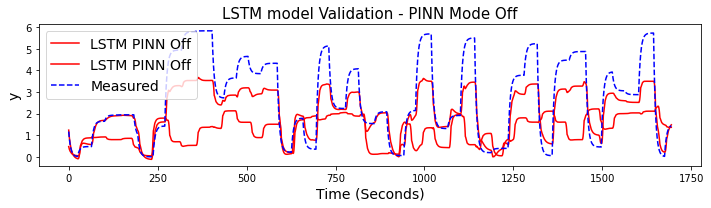

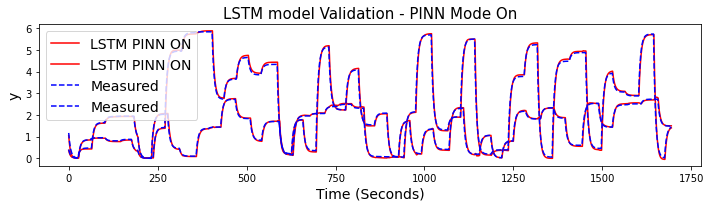

In [21]:
Ym_val = data3[['y1','y2']].to_numpy()[window:]


plt.figure(0, figsize=(10,3))
# plt.subplot(2,1,1)
plt.plot(Ytu_nn_off[window:],'r-',label='LSTM PINN Off')
plt.plot(Ym_val[:,0],'b--',label='Measured')
plt.title('LSTM model Validation - PINN Mode Off',fontsize=15)
plt.ylabel("y", fontsize=14)
plt.xlabel("Time (Seconds)", fontsize=14)
plt.legend(loc=2,fontsize=14)
plt.tight_layout()

plt.savefig(path + 'FOPDT_mimo_PINN_Training_result_PINN_Off.eps', format='eps')
plt.savefig(path + 'FOPDT_mimo_PINN_Training_result_PINN_Off.png', format='png')


plt.figure(1, figsize=(10,3))
# plt.subplot(2,1,2)
plt.plot(Ytu_nn_on[window:],'r-',label='LSTM PINN ON')
plt.plot(Ym_val,'b--',label='Measured')
plt.title('LSTM model Validation - PINN Mode On',fontsize=15)
plt.ylabel("y", fontsize=14)
plt.xlabel("Time (Seconds)", fontsize=14)
plt.legend(loc=2,fontsize=14)
plt.tight_layout()

plt.savefig(path + 'FOPDT_mimo_PINN_Training_result_PINN_On.eps', format='eps')
plt.savefig(path + 'FOPDT_mimo_PINN_Training_result_PINN_On.png', format='png')

plt.show()